In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install patchify
!pip install -q monai

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
     

In [3]:
import numpy as np

def get_bounding_box(ground_truth_map):
    """Get a bounding box from a ground truth map
    Args:
        ground_truth_map (np.array): Ground truth map
        Returns:
            bbox (list): Bounding box coordinates"""
    # Check if the ground truth map is empty
    if np.sum(ground_truth_map) == 0:
        return [0, 0, ground_truth_map.shape[1], ground_truth_map.shape[0]]

    # Get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    # Add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [4]:
import os
import numpy as np
from PIL import Image
from datasets import Dataset
from torch.utils.data import Dataset as TorchDataset
from sklearn.model_selection import train_test_split

class WaterDatasetLoader:

    """
    A class used to load and preprocess a dataset of water images and their corresponding annotations.

    ...

    Attributes
    ----------
    dataset_root : str
        The root directory of the dataset
    image_subfolder : str
        The subfolder within the root directory that contains the images
    annotation_subfolder : str
        The subfolder within the root directory that contains the annotations
    image_paths : list
        A list of paths to the images in the dataset
    annotation_paths : list
        A list of paths to the annotations in the dataset

    Methods
    -------
    load_paths():
        Loads the paths of the images and annotations into the respective lists.
    load_and_preprocess_image(image_path, target_size=(256, 256), dtype=np.uint8):
        Loads and preprocesses an image from the given path.
    load_and_preprocess_annotation(annotation_path, target_size=(256, 256), dtype=np.uint8):
        Loads and preprocesses an annotation from the given path.
    create_dataset():
        Creates a dataset from the loaded and preprocessed images and annotations.
    """

    def __init__(self, dataset_root, image_subfolder, annotation_subfolder):
         
        """
        Constructs all the necessary attributes for the WaterDatasetLoader object.

        Parameters
        ----------
            dataset_root : str
                The root directory of the dataset
            image_subfolder : str
                The subfolder within the root directory that contains the images
            annotation_subfolder : str
                The subfolder within the root directory that contains the annotations
        """

        self.dataset_root = dataset_root
        self.image_subfolder = image_subfolder
        self.annotation_subfolder = annotation_subfolder
        self.image_paths = []
        self.annotation_paths = []
        self.load_paths()

    def load_paths(self):
        """
        Loads the paths of the images and annotations into the respective lists.
        """
        for root, dirs, files in os.walk(self.dataset_root):
            if self.image_subfolder in root:
                for filename in files:
                    if filename.endswith(".png"):
                        image_path = os.path.join(root, filename)
                        annotation_path = image_path.replace(self.image_subfolder, self.annotation_subfolder).replace(".png", ".png")
                        if os.path.exists(annotation_path):
                            self.image_paths.append(image_path)
                            self.annotation_paths.append(annotation_path)
                        else:
                            print(f"Warning: Annotation file not found for image {image_path}")
        if len(self.image_paths) != len(self.annotation_paths):
            print("Warning: Mismatch between the number of images and annotations.")

    @staticmethod
    def load_and_preprocess_image(image_path, target_size=(256, 256), dtype=np.uint8):
        """
        Loads and preprocesses an image from the given path.

        Parameters
        ----------
            image_path : str
                The path to the image
            target_size : tuple, optional
                The target size of the image (default is (256, 256))
            dtype : data-type, optional
                The desired data-type for the image (default is np.uint8)

        Returns
        -------
            img : ndarray
                The loaded and preprocessed image
        """
        img = Image.open(image_path)
        img = img.resize(target_size)
        img = np.array(img, dtype=dtype)
        return img

    @staticmethod
    def load_and_preprocess_annotation(annotation_path, target_size=(256, 256), dtype=np.uint8):
        """
        Loads and preprocesses an annotation from the given path.

        Parameters
        ----------
            annotation_path : str
                The path to the annotation
            target_size : tuple, optional
                The target size of the annotation (default is (256, 256))
            dtype : data-type, optional
                The desired data-type for the annotation (default is np.uint8)

        Returns
        -------
            ann : ndarray
                The loaded and preprocessed annotation
        """
        ann = Image.open(annotation_path)
        ann = ann.resize(target_size)
        ann = np.array(ann, dtype=dtype) / 255
        return ann

    def create_dataset(self):
        """
        Creates a dataset from the loaded and preprocessed images and annotations.

        Returns
        -------
            train_dataset : Dataset
                The training dataset
            test_dataset : Dataset
                The testing dataset
        """
        images = [self.load_and_preprocess_image(path) for path in self.image_paths]
        annotations = [self.load_and_preprocess_annotation(path) for path in self.annotation_paths]
        images = np.array(images, dtype=np.uint8)
        annotations = np.array(annotations, dtype=np.uint8)

        # dataset_dict = {
        #     "image": [Image.fromarray(img, 'RGB') for img in images],
        #     "label": [Image.fromarray(ann, 'L') for ann in annotations[:, :, :, 0]],
        # }  
        images_train, images_test, annotations_train, annotations_test = train_test_split(images, annotations, test_size=0.2, random_state=42)
        train_dataset_dict = { 
            "image": [Image.fromarray(img, 'RGB') for img in images_train],
            "label": [Image.fromarray(ann, 'L') for ann in annotations_train[:, :, :, 0]],
        }
        test_dataset_dict = {
            "image": [Image.fromarray(img, 'RGB') for img in images_test],
            "label": [Image.fromarray(ann, 'L') for ann in annotations_test[:, :, :, 0]],
        }
        train_dataset = Dataset.from_dict(train_dataset_dict)
        test_dataset = Dataset.from_dict(test_dataset_dict)
        # return Dataset.from_dict(dataset_dict)
        return train_dataset, test_dataset

# Code taken from: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb
class SAMDataset(TorchDataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])
        prompt = get_bounding_box(ground_truth_mask)
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["ground_truth_mask"] = ground_truth_mask
        return inputs



In [7]:
!ls

EfficientSAM  UNet-WaterBodySegmentation.h5  start.sh
MainDir       requirements.txt


In [5]:
from torch.utils.data import DataLoader
from transformers import SamProcessor, SamModel

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

batch_size=20

dataset_root = "./MainDir/Untitled Folder/water_v1"
image_subfolder = "JPEGImages/ADE20K"
annotation_subfolder = "Annotations/ADE20K"

loader = WaterDatasetLoader(dataset_root, image_subfolder, annotation_subfolder)
loader.load_paths()
train_data, test_data = loader.create_dataset()
train_dataset = SAMDataset(dataset=train_data, processor= processor)
test_dataset = SAMDataset(dataset=test_data, processor= processor)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size= batch_size, shuffle=True, drop_last=False)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

# Dataset

In [10]:
images.shape

(2167, 256, 256, 3)

In [11]:
annotations.shape

(2167, 256, 256, 3)

In [12]:
import numpy as np

# Assuming you have 'images' and 'annotations' as (2167, 256, 256, 3) arrays
# You can remove the last dimension (3) like this:

images = images[:, :, :, 0]  # This keeps only the red channel
annotations = annotations[:, :, :, 0]  # This keeps only the red channel

# Now 'images' and 'annotations' will be (2167, 256, 256) arrays.


In [13]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img,'L') for img in images],
    "label": [Image.fromarray(ann,'L') for ann in annotations],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [14]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2167
})

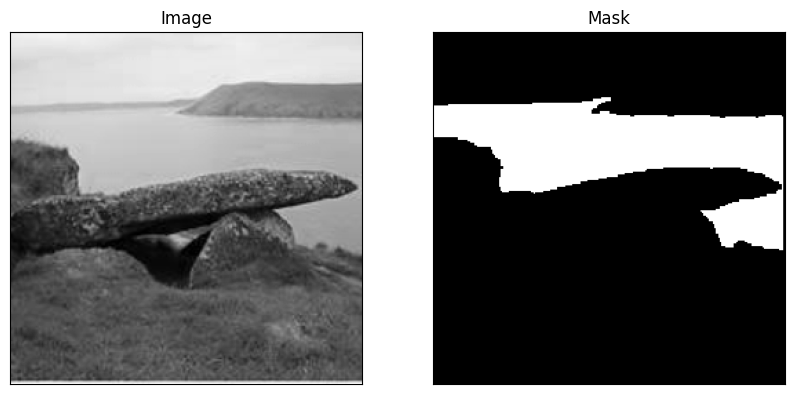

In [15]:
img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [16]:

#Desired patch size for smaller images and step size.
patch_size = 256
step = 256
     

In [17]:
# #Get bounding boxes from mask.
# def get_bounding_box(ground_truth_map):
#     # get bounding box from mask
#     y_indices, x_indices = np.where(ground_truth_map > 0)
#     x_min, x_max = np.min(x_indices), np.max(x_indices)
#     y_min, y_max = np.min(y_sindices), np.max(y_indices)
#     # add perturbation to bounding box coordinates
#     H, W = ground_truth_map.shape
#     x_min = max(0, x_min - np.random.randint(0, 20))
#     x_max = min(W, x_max + np.random.randint(0, 20))
#     y_min = max(0, y_min - np.random.randint(0, 20))
#     y_max = min(H, y_max + np.random.randint(0, 20))
#     bbox = [x_min, y_min, x_max, y_max]

#     return bbox
# def get_bounding_box(ground_truth_map):
#     x_indices, y_indices = np.where(ground_truth_map > 0)
#     if len(x_indices) == 0:
#         # Handle the case where there are no non-zero values in the map
#         return 0, 0, 0, 0

#     x_min, x_max = np.min(x_indices), np.max(x_indices)
#     y_min, y_max = np.min(y_indices), np.max(y_indices)

#     # Add perturbation to bounding box coordinates
#     H, W = ground_truth_map.shape  # Access the height (H) and width (W)
#     x_min = max(0, x_min - np.random.randint(0, 20))
#     x_max = min(W, x_max + np.random.randint(0, 20))
#     y_min = max(0, y_min - np.random.randint(0, 20))
#     y_max = min(H, y_max + np.random.randint(0, 20))
    
#     input_boxes = [[[float(x_min), float(y_min), float(x_max), float(y_max)]]]

#     return input_boxes

# #Get bounding boxes from mask.
# def get_bounding_box(ground_truth_map):
#     # get bounding box from mask
#     y_indices, x_indices = np.where(ground_truth_map > 0)
#     x_min, x_max = np.min(x_indices), np.max(x_indices)
#     y_min, y_max = np.min(y_indices), np.max(y_indices)
#     # add perturbation to bounding box coordinates
#     H, W = ground_truth_map.shape
#     x_min = max(0, x_min - np.random.randint(0, 20))
#     x_max = min(W, x_max + np.random.randint(0, 20))
#     y_min = max(0, y_min - np.random.randint(0, 20))
#     y_max = min(H, y_max + np.random.randint(0, 20))
#     bbox = [x_min, y_min, x_max, y_max]

#     return bbox


import numpy as np

def get_bounding_box(ground_truth_map):
    # Check if the ground truth map is empty
    if np.sum(ground_truth_map) == 0:
        return [0, 0, ground_truth_map.shape[1], ground_truth_map.shape[0]]

    # Get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    # Add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox


In [18]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    
    """
    This class is used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])
        prompt = get_bounding_box(ground_truth_mask)
        inputs = self.processor(image,input_boxes=[[prompt]], return_tensors="pt")
    # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs
     

In [19]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [20]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [21]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [34]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=False)

In [35]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([4, 3, 1024, 1024])
original_sizes torch.Size([4, 2])
reshaped_input_sizes torch.Size([4, 2])
input_boxes torch.Size([4, 1, 4])
ground_truth_mask torch.Size([4, 256, 256])


In [36]:
batch["ground_truth_mask"].shape

torch.Size([4, 256, 256])

In [37]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)
     

In [38]:
from torch.optim import Adam
from monai.losses import DiceCELoss

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')


In [43]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [44]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()


for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

      # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 542/542 [10:36<00:00,  1.17s/it]


EPOCH: 0
Mean loss: 0.2995333642702261


100%|██████████| 542/542 [10:37<00:00,  1.18s/it]


EPOCH: 1
Mean loss: 0.2651158973052273


100%|██████████| 542/542 [10:38<00:00,  1.18s/it]


EPOCH: 2
Mean loss: 0.2601230481014041


100%|██████████| 542/542 [10:37<00:00,  1.18s/it]


EPOCH: 3
Mean loss: 0.24925736826586767


100%|██████████| 542/542 [10:37<00:00,  1.18s/it]


EPOCH: 4
Mean loss: 0.24291411900679782


100%|██████████| 542/542 [10:34<00:00,  1.17s/it]


EPOCH: 5
Mean loss: 0.23610535602178082


100%|██████████| 542/542 [10:35<00:00,  1.17s/it]


EPOCH: 6
Mean loss: 0.22763632325201236


100%|██████████| 542/542 [10:36<00:00,  1.17s/it]


EPOCH: 7
Mean loss: 0.22185803900345666


100%|██████████| 542/542 [10:35<00:00,  1.17s/it]


EPOCH: 8
Mean loss: 0.22064154832263055


100%|██████████| 542/542 [10:40<00:00,  1.18s/it]

EPOCH: 9
Mean loss: 0.21346455535463082


In [45]:
torch.save(model.state_dict(), "/kaggle/working/wase_model_checkpoint.pth")

In [46]:

from transformers import SamModel, SamConfig, SamProcessor
import torch

In [48]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_wase_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_wase_model.load_state_dict(torch.load("/kaggle/working/wase_model_checkpoint.pth"))


<All keys matched successfully>

In [49]:

# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_wase_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

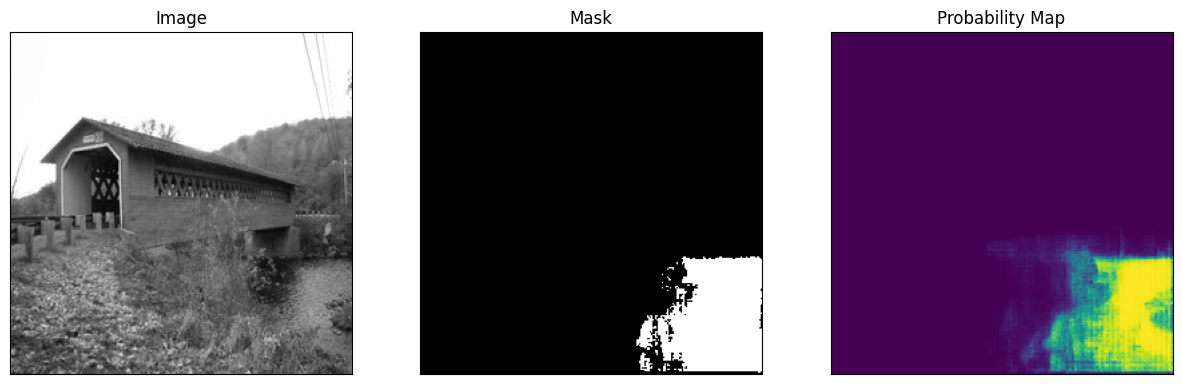

In [51]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_wase_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_wase_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [52]:
from PIL import Image

#Apply a trained model on large image
large_test_image = "/kaggle/input/wastewater/WhatsApp Grsel 2023-09-25 saat 17.24.04.jpg"
img = Image.open(large_test_image)
img = img.convert("L")
n_im = np.ndarray(img).astype(np.float32)
print(n_im.shape)
patches = patchify(im, (256, 256), step=256)  #Step=256 for 256 patches means no overlap


TypeError: expected a sequence of integers or a single integer, got '<PIL.Image.Image image mode=L size=768x1024 at 0x7F1A147120B0>'

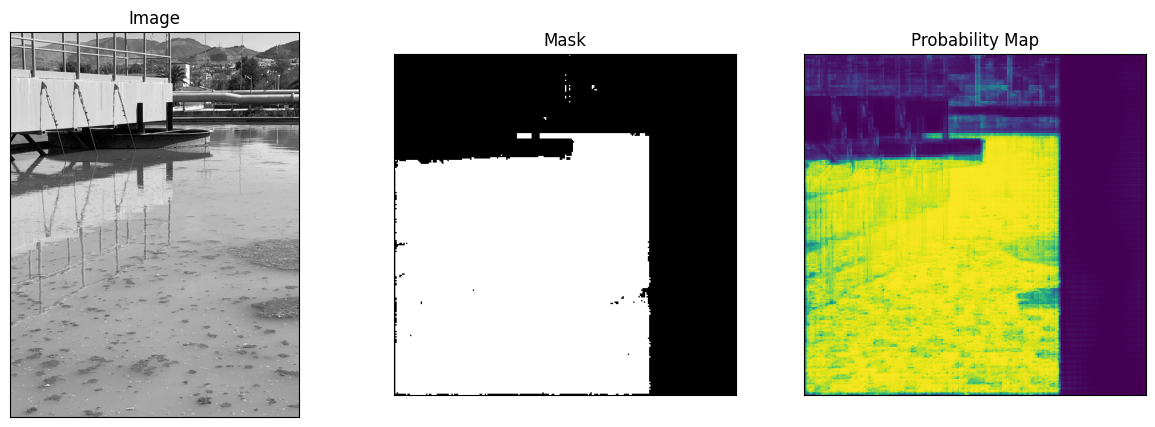

In [57]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Load a normal image (you need to specify the path to your image)
normal_image_path = "/kaggle/input/wastewater/WhatsApp Grsel 2023-09-25 saat 17.24.05.jpg"
test_image = Image.open(normal_image_path)
test_image = test_image.convert("L")
# Get the box prompt based on the image size (you may need to adjust this based on your use case)
prompt = [0, 0, test_image.width, test_image.height]

# # Prepare the image + box prompt for the model
# inputs = processor(test_image, input_boxes=[prompt], return_tensors="pt")
# Modify the prompt to be in the expected format
prompt = [[prompt]]  # Wrap it in an extra list

# Prepare the image + box prompt for the model
inputs = processor(test_image, input_boxes=prompt, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

# Set the model to evaluation mode
my_wase_model.eval()

# Forward pass
with torch.no_grad():
    outputs = my_wase_model(**inputs, multimask_output=False)

# Apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# Convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

# Create a figure for plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image on the left
axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Image")

# Plot the segmentation mask in the middle
axes[1].imshow(medsam_seg, cmap='gray')
axes[1].set_title("Mask")

# Plot the probability map on the right
axes[2].imshow(medsam_seg_prob, cmap='viridis')  # You can choose a different colormap
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()
